In [138]:
import logging
import math
from dataclasses import dataclass
from itertools import chain
from pathlib import Path
from typing import List, Collection, Callable, Tuple, Set

import click
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import (
    Range1d,
    Plot,
    Circle,
    MultiLine,
    LinearColorMapper,
    ColorBar,
    BasicTicker,
    HoverTool,
    BoxZoomTool,
    ResetTool,
    PanTool,
    WheelZoomTool,
    UndoTool,
    SaveTool,
    ColumnDataSource,
    LabelSet,
)
from bokeh.palettes import inferno, Category20
from bokeh.plotting import from_networkx
from scipy import stats
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("ggplot")
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
%matplotlib inline

WIDTH = 1280
HEIGHT = 720
DELIM = ","
PAIR_IDX = ("sample1", "sample2")
PALETTE = Category20[20]  # effectively 10 cycles of 20 colours


class AsymmetrixMatrixError(Exception):
    pass


def parse_threshold(ctx, param, value):
    try:
        return [int(t) for t in value.split(",")]
    except ValueError:
        raise click.BadParameter(
            "threshold values must be integers, and if providing multiple, must be comma-separated"
        )


def parse_samples(ctx, param, value):
    return value.split(",")


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.Series:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


def dist_matrix_to_graph(mx: pd.Series, threshold: int, include_singletons: bool=False) -> nx.Graph:
    edges = [(s1, s2, dist) for (s1, s2), dist in mx.iteritems() if dist <= threshold]
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)
    if include_singletons:
        samples = set()
        for u in chain.from_iterable(mx.index):
            if u not in samples:
                graph.add_node(u)
                samples.add(u)
            if u not in samples:
                graph.add_node(v)
                samples.add(v)
    return graph


def fit(xs: List[int], ys: List[int]) -> Callable:
    """Determines the line of best fit for the given distances and returns the linear equation
    as a function that takes a threshold, x, and returns the equivalent threshold for the data
    passed to this function.
    Note: xs should be the 'truth' distance values"""
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(xs, ys)

    def threshold_converter(threshold: float) -> float:
        """y = mx + c, where x is the threshold"""
        return slope * threshold + intercept

    return threshold_converter

def connected_components(G: nx.Graph, node: str) -> Set[str]:
    if node not in G:
        return set()
    return nx.node_connected_component(G, node)

def clustered_together(u: str, v: str, G: nx.Graph) -> bool:
    ucc = connected_components(G, u)
    if not ucc:
        return False
    
    vcc = connected_components(G, v)
    if not vcc:
        return False
    
    return ucc == vcc


# Using Tversky Index to calculate Recall and Precision of clusters

A deeper explanation of this metric can be found at https://github.com/mbhall88/head_to_head_pipeline/issues/65#issuecomment-797895910

In [117]:
def tversky_index(A: Set[str], B: Set[str], alpha: float = 1.0, beta: float = 1.0) -> float:
    """If we set alpha and beta to 1 then we get the Jaccard Index. 
    If we set alpha to 1 and beta to 0 we get something like recall. 
    If we set alpha to 0 and beta to 1 we get something like precision.
    """
    size_of_intersection = len(A & B)
    A_weight = alpha * len(A - B)
    B_weight = beta * len(B - A)
    denominator = size_of_intersection + A_weight + B_weight
    
    try:
        return size_of_intersection / denominator
    except ZeroDivisionError:
        return 0

def set_precision(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=0, beta=1)

def set_recall(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=1, beta=0)

In [118]:
def excess_clustering_rate(A: Set[str], B: Set[str]) -> float:
    """What percentage of true singletons are clustered.
    What percentage of A is not in B
    """
    return len(A - B) / len(A)

In [119]:
def XCR(G, H):
    expected_singletons = set(nx.isolates(G))
    actual_singletons = set(nx.isolates(H))
    denom = len(expected_singletons)
    numer = len(expected_singletons - actual_singletons)
    xcr = numer / denom
    return xcr, numer, denom

def connected_components(G: nx.Graph, node: str) -> Set[str]:
    if node not in G:
        return set()
    return nx.node_connected_component(G, node)

def SACP_AND_SACR(G, H):
    G.remove_nodes_from(list(nx.isolates(G)))
    H.remove_nodes_from(list(nx.isolates(H)))
    
    expected_clusters = list(nx.connected_components(G))
    actual_clusters = list(nx.connected_components(H))
    ppvs = []
    tprs = []
    for i, expected_cluster in enumerate(expected_clusters):
        cluster_ppv = []
        cluster_tpr = []
        for node in expected_cluster:
            actual_cluster = connected_components(H, node)
            tpr = set_recall(expected_cluster, actual_cluster)
            ppv = set_precision(expected_cluster, actual_cluster)
            cluster_ppv.append(ppv)
            cluster_tpr.append(tpr)
        ppvs.extend(cluster_ppv)
        tprs.extend(cluster_tpr)
    return np.mean(ppvs), np.mean(tprs)

In [222]:
bcftools_ts = {0: 0, 2: 2, 5: 5, 12: 11}
map_ts = {0: 16, 2: 18, 5: 18, 12: 27}
compare_ts = {0: 0, 2: 1, 5: 3, 12: 7}
t = 0

compass_mtx = load_matrix("compass.matrix.csv", name="compass")
G_compass = dist_matrix_to_graph(compass_mtx, threshold=t, include_singletons=True)
bcftools_mtx = load_matrix("bcftools.matrix.csv", name="bcftools")
G_bcftools = dist_matrix_to_graph(bcftools_mtx, threshold=bcftools_ts[t], include_singletons=True)
map_mtx = load_matrix("pandora_single.matrix.csv", name="map")
G_map = dist_matrix_to_graph(map_mtx, threshold=map_ts[t], include_singletons=True)
compare_mtx = load_matrix("pandora_multi.matrix.csv", name="compare")
G_compare = dist_matrix_to_graph(compare_mtx, threshold=compare_ts[t], include_singletons=True)

In [223]:
assert len(G_compass.nodes) == 150

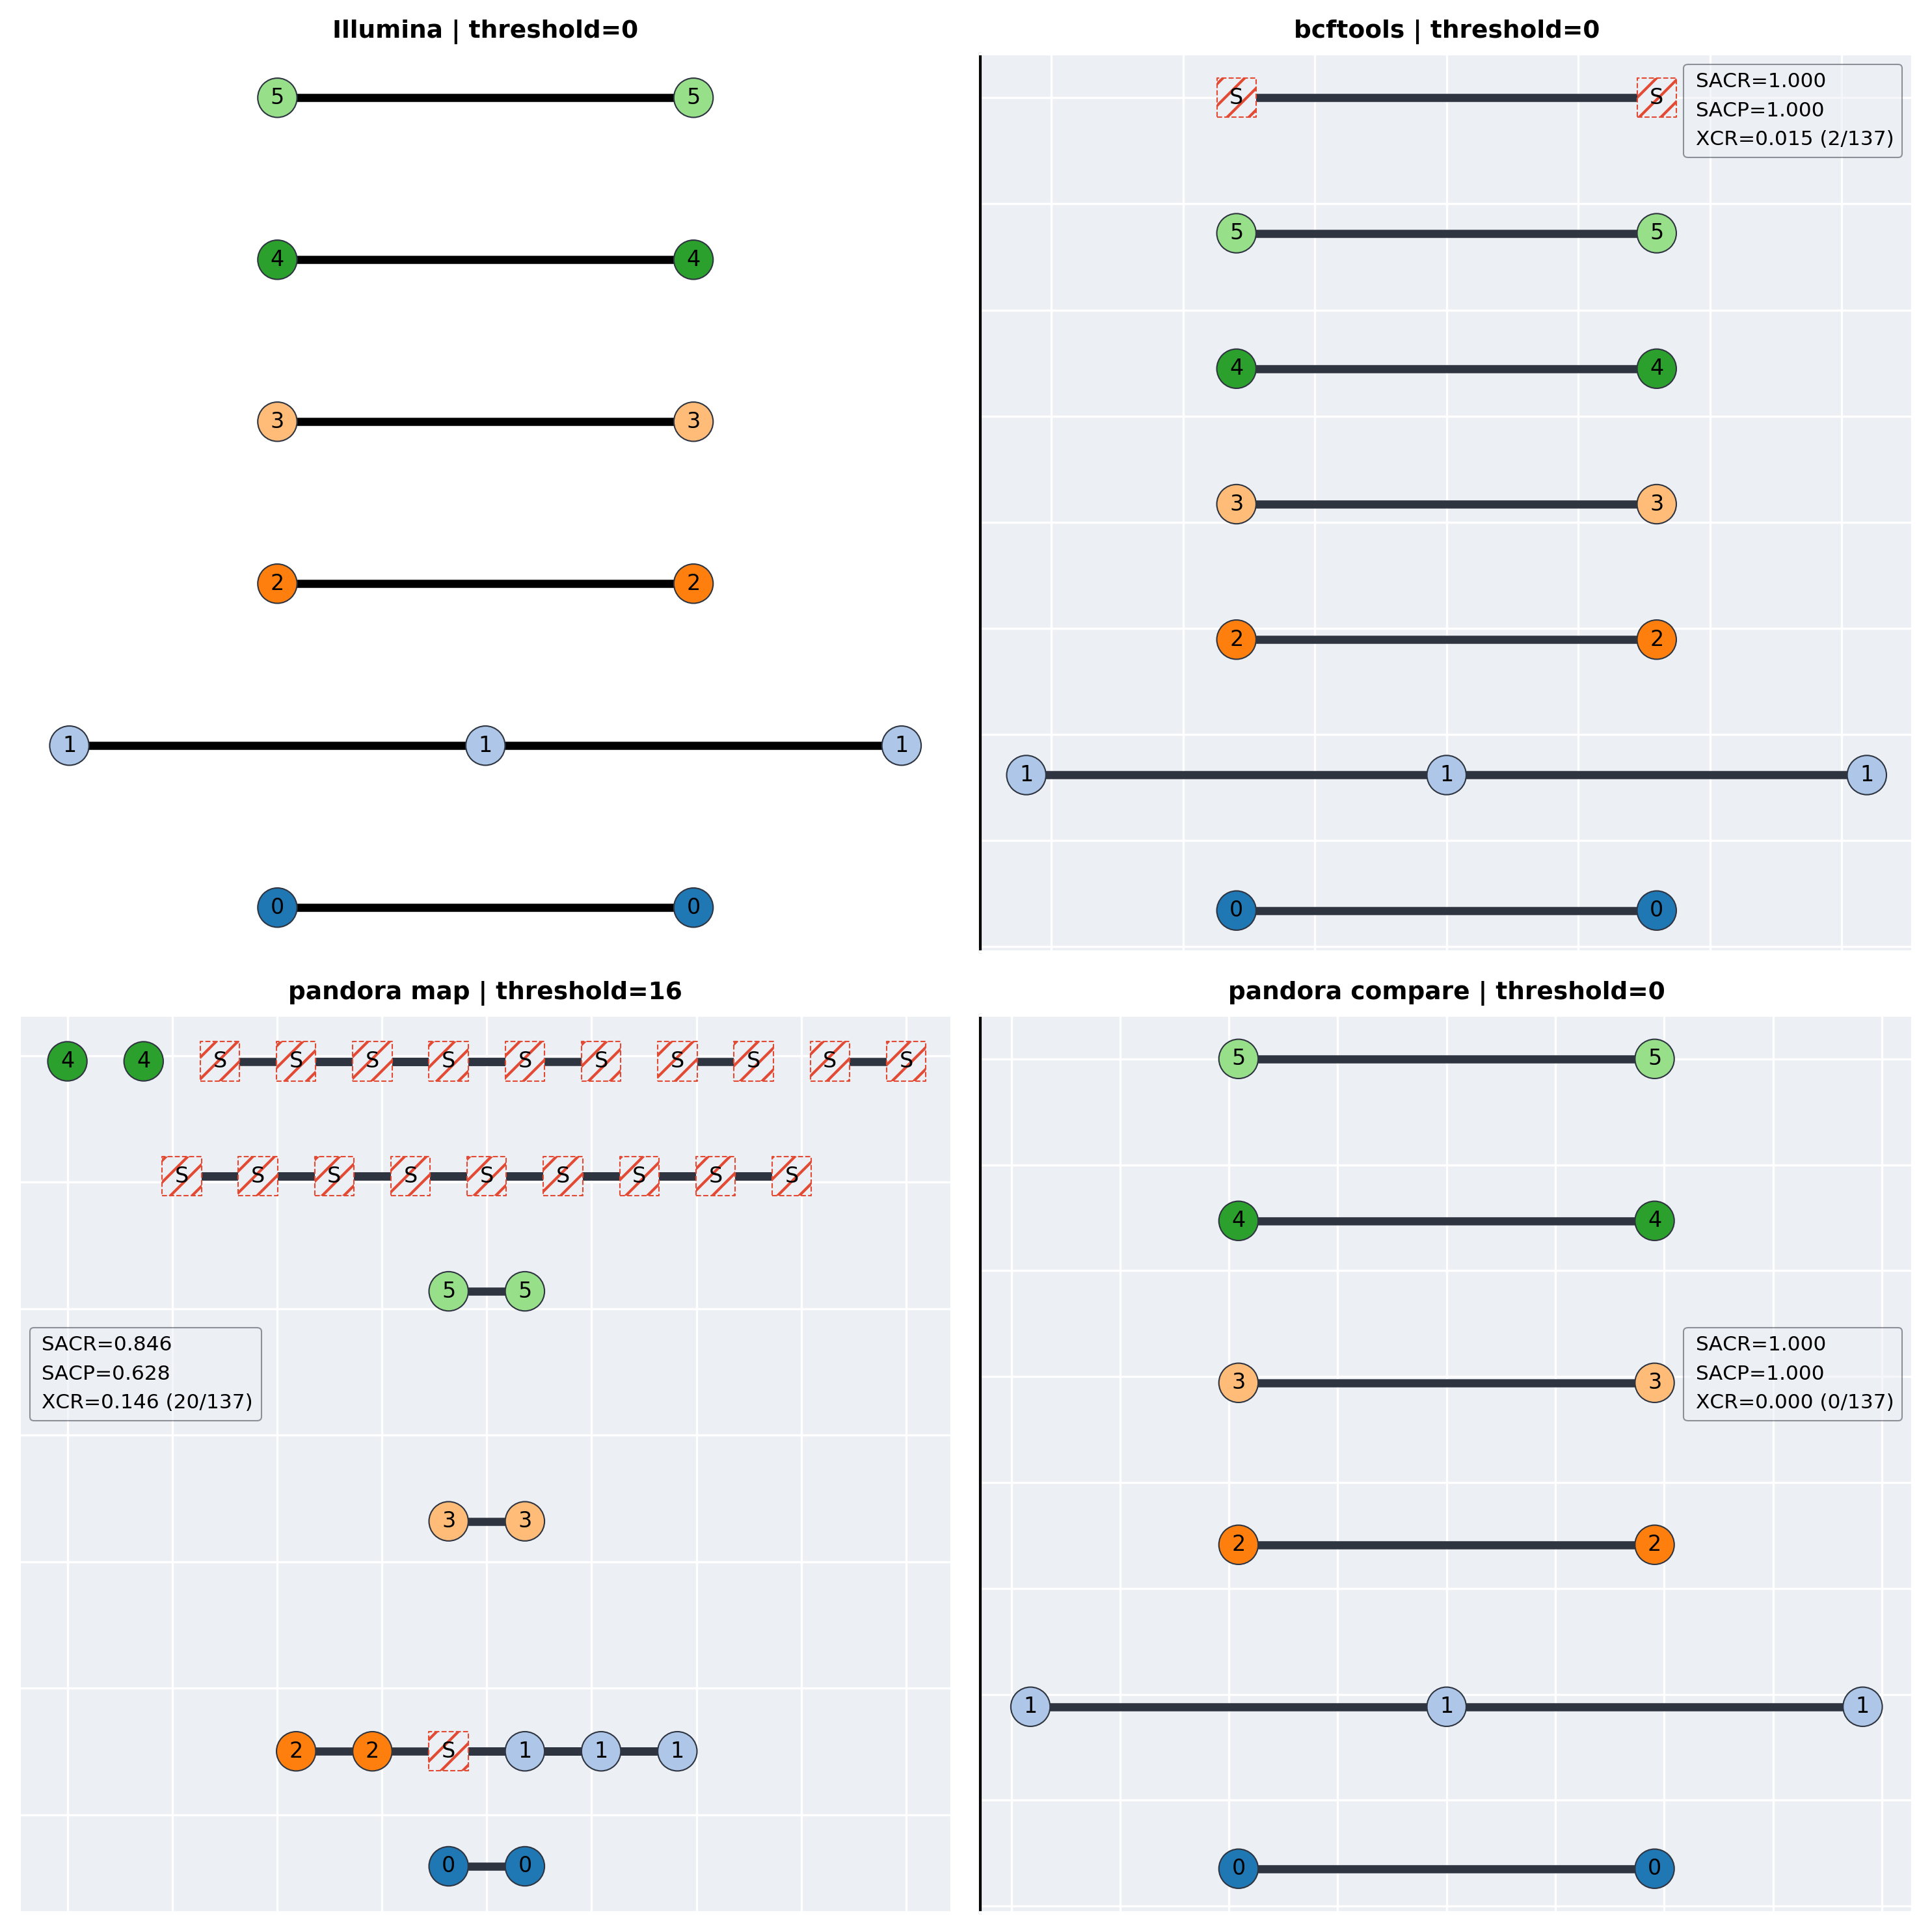

In [224]:
G = dist_matrix_to_graph(compass_mtx, threshold=t, include_singletons=True)
# grid_kwargs = dict(hspace=0.1, wspace=0)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), dpi=300, )#gridspec_kw=grid_kwargs)

node_size = 210
edge_width = 3
lw = 1
font_size = 8
fw = "normal"
title_fontdict = dict(fontsize=9, fontweight="bold") 
align = "horizontal"
black = "#2e3440"
white = "#eceff4"
red = ggplot_cm[0]
edge_colour = black
singleton_label = "S"
singleton_id = -1
singleton_node_colour = white
singleton_line_colour = red
singleton_lw = 3
singleton_shape = "s"  # square
singleton_hatch = "///"
singleton_ls = "--"
node_shape = "o"  # circle
colour_idx = -1
subset_key = "cluster_id"
node_colour_key = "node_colour"
label_key = "label"

node_colours = dict()
cluster_id = dict()
cluster_labels = dict()

for cluster in nx.connected_components(G):
    if len(cluster) == 1:
        colour = singleton_node_colour
    else:
        colour_idx += 1
        colour = PALETTE[colour_idx]
    for v in cluster:
        node_colours[v] = colour
        if colour == singleton_node_colour:
            cluster_id[v] = singleton_id
            cluster_labels[v] = singleton_label
        else:
            cluster_id[v] = colour_idx
            cluster_labels[v] = str(colour_idx)
    
max_cluster_id = colour_idx + 1

for k, v in cluster_id.items():
    if v == singleton_id:
        cluster_id[k] = max_cluster_id
        
singleton_id = max_cluster_id


nx.set_node_attributes(G, node_colours, node_colour_key)
nx.set_node_attributes(G, cluster_id, subset_key)
nx.set_node_attributes(G, cluster_labels, label_key)

# remove singletons
G.remove_nodes_from(list(nx.isolates(G)))


# add Illumina clustering plot
ax = axes.flatten()[0]

pos = nx.multipartite_layout(G, subset_key=subset_key, align=align)
cols = [d[node_colour_key] for v, d in G.nodes(data=True)]
labs = {v: d[label_key] for v, d in G.nodes(data=True)}

nx.draw(G, pos=pos, ax=ax, node_color=cols, 
        font_size=font_size, labels=labs, 
        edgecolors=edge_colour, font_weight=fw,
       node_size=node_size, width=edge_width)

ax.set_title(f"Illumina | threshold={t}", fontdict=title_fontdict)


for i, (M, T, tool) in enumerate(zip(
    [bcftools_mtx, map_mtx, compare_mtx], 
    [bcftools_ts, map_ts, compare_ts], 
    ["bcftools", "pandora map", "pandora compare"]
), start=1):
    ax = axes.flatten()[i]
    tool_t = T[t]
    H = dist_matrix_to_graph(M, threshold=tool_t, include_singletons=True)
    xcr_data = XCR(G_compass.copy(), H.copy())
    
    nx.set_node_attributes(H, node_colours, node_colour_key)
    nx.set_node_attributes(H, cluster_id, subset_key)
    nx.set_node_attributes(H, cluster_labels, label_key)
    
    # remove singletons that were also singletons in Illumina
    for v in list(nx.isolates(H)):
        if node_colours[v] == singleton_node_colour:  # is also singleton in Illumina
            H.remove_node(v)
        else:  # is not singleton in Illumina
            H.nodes[v][subset_key] = singleton_id
            
    # give nodes that were singleton on Illumina, but now clustered
    # in Nanopore the cluster ID of their nanopore cluster
#     clustered_singletons = {v for v, d in H.nodes(data=True) if d[node_colour_key] == singleton_node_colour}
#     for v in clustered_singletons:
#         new_id = -1
#         for u in nx.node_connected_component(H, v):
#             if H.nodes[u][node_colour_key] == singleton_node_colour:
#                 continue
#             else:
#                 new_id = G.nodes[u][subset_key]
#                 break

#         H.nodes[v][subset_key] = new_id
    clusters = nx.connected_components(H)
    for c in clusters:
        ids = {H.nodes[v][subset_key] for v in c}
        if len(ids) == 1:
            continue
        sorted_ids = sorted(ids)
        new_id = sorted_ids[0]

        for v in c:
            H.nodes[v][subset_key] = new_id
            
    # if there are more than n nodes in the singletons line, split over more lines
    n = 10
    count = 0
    new_id = singleton_id + 1
    to_change = []
    for v, d in H.nodes(data=True):
        if d[subset_key] == singleton_id:
            count += 1
            if count >= n:
                to_change.append(v)
            
    for v in to_change:
        H.nodes[v][subset_key] = new_id
        for u in connected_components(H, v):
            H.nodes[u][subset_key] = new_id

    pos = nx.multipartite_layout(H, subset_key=subset_key, align=align)
    labs = {v: d[label_key] for v, d in H.nodes(data=True)}
    sacp, sacr = SACP_AND_SACR(dist_matrix_to_graph(compass_mtx, threshold=t, include_singletons=False), dist_matrix_to_graph(M, threshold=tool_t, include_singletons=False))

    for shape in [singleton_shape, node_shape]:
        if shape == singleton_shape:
            vs = [k for k, v in labs.items() if v == singleton_label]
        else:
            vs = [k for k, v in labs.items() if v != singleton_label]
        ps = {v: pos[v] for v in vs}
        cols = [H.nodes[v][node_colour_key] for v in vs]
        
        node_ax = nx.draw_networkx_nodes(
            H, pos=ps, nodelist=vs, node_color=cols, 
            node_shape=shape, edgecolors=edge_colour, ax=ax,
            node_size=node_size
        )
        if shape == singleton_shape:
            node_ax.set_hatch(singleton_hatch)
            node_ax.set_edgecolor(singleton_line_colour)
            node_ax.set_linestyle(singleton_ls)
        

    nx.draw_networkx_edges(H, pos, ax=ax, edge_color=edge_colour, width=edge_width)
    nx.draw_networkx_labels(H, pos, labels=labs, ax=ax, font_size=font_size, font_weight=fw)
    
    fs = 7.5
    
    c = mpatches.Circle((1, 1), 0.0001, color=white)
#     ax.add_patch(c)
    metrics = [f"SACR={sacr:.3f}", f"SACP={sacp:.3f}", f"XCR={xcr_data[0]:.3f} ({xcr_data[1]}/{xcr_data[2]})"]
    
    if i == 1:
        location = dict(loc="upper right")#bbox_to_anchor=(0.99, 0.5))
    elif i == 2:
        location = dict(loc="center left", bbox_to_anchor=(0, 0.6))
    elif i == 3:
        location = dict(loc="center right", bbox_to_anchor=(1, 0.6))
    
    ax.legend(
        [c]*len(metrics), metrics, facecolor=white, handlelength=0.1, handletextpad=0.1,
        fontsize=fs, framealpha=0.5, edgecolor=black, frameon=True, **location
    )

    ax.set_title(f"{tool} | threshold={tool_t}", fontdict=title_fontdict)
        
#     if i / 2 <= 1:
#         ax.spines["bottom"].set_color("black")
        
    _ = ax.set_facecolor(white)
    

axes[0][1].spines["left"].set_color("black")
axes[1][1].spines["left"].set_color("black")
# axes[0][1].spines["bottom"].set_color("black")
# axes[0][0].spines["bottom"].set_color("black")

plt.tight_layout()

In [221]:
fig.savefig(f"clustering-t{t}.png")

# Threshold sweeps

In [23]:
G = G_compass
H = G_bcftools
M = compass_mtx
N = bcftools_mtx
true_clusters = (c for c in nx.connected_components(G))
print("Size\tPPV\tTPR")
for i, cluster in enumerate(true_clusters):
    cluster_ppv = []
    cluster_tpr = []
    for node in cluster:
        test_cluster = connected_components(H, node)
        tpr = set_recall(cluster, test_cluster)
        ppv = set_precision(cluster, test_cluster)
        cluster_ppv.append(ppv)
        cluster_tpr.append(tpr)
    print(f"{len(cluster)}\t{np.mean(cluster_ppv):.2f}\t{np.mean(cluster_tpr):.2f}")

Size	PPV	TPR
2	1.00	1.00
7	0.70	1.00
2	0.20	1.00
2	1.00	1.00
2	1.00	1.00
2	0.67	1.00
2	1.00	1.00
6	0.75	1.00
2	0.25	1.00
6	1.00	1.00
2	1.00	1.00
2	1.00	1.00
2	1.00	1.00
2	1.00	1.00
2	1.00	1.00
2	1.00	1.00
3	1.00	1.00
3	1.00	1.00
2	1.00	1.00


In [24]:
from itertools import chain
samples = set(np.unique(np.array(list(chain.from_iterable(compass_mtx.index)))))

In [25]:
data = []
distances = [0, 2, 5, 12]
ont_dists = list(range(0, 15))
# print("Dist.\tThresh.\tSize\tPPV\tTPR")
for d in distances:
    T = dist_matrix_to_graph(M, threshold=d)
    true_clusters = [c for c in nx.connected_components(T)]
    true_singletons = samples - set(T.nodes)
    for t in ont_dists:
        g = dist_matrix_to_graph(N, threshold=t)
        num_test_clusters = len(list(nx.connected_components(g)))
        test_singletons = samples - set(g.nodes)
        xcr = excess_clustering_rate(true_singletons, test_singletons)
        try:
            n_diff = len(true_clusters) / num_test_clusters
        except ZeroDivisionError:
            n_diff = 0
        for i, cluster in enumerate(true_clusters):
            cluster_ppv = []
            cluster_tpr = []
            for node in cluster:
                test_cluster = connected_components(g, node)
                tpr = set_recall(cluster, test_cluster)
                ppv = set_precision(cluster, test_cluster)
                cluster_ppv.append(ppv)
                cluster_tpr.append(tpr)
                data.append((d, t, tpr, ppv, 1-xcr))
#             print(f"{d}\t{t}\t{len(cluster)}\t{np.mean(cluster_ppv):.2f}\t{np.mean(cluster_tpr):.2f}")

In [26]:
df = pd.DataFrame(
    data, 
    columns=["distance", "threshold", "SACR", "SACP", "1-XCR"]
).melt(id_vars=["distance", "threshold"], var_name="metric")

        count      mean           std       min       25%       50%       75%  \
metric                                                                          
1-XCR    13.0  0.951807  1.155557e-16  0.951807  0.951807  0.951807  0.951807   
SACP     13.0  1.000000  0.000000e+00  1.000000  1.000000  1.000000  1.000000   
SACR     13.0  1.000000  0.000000e+00  1.000000  1.000000  1.000000  1.000000   

             max  
metric            
1-XCR   0.951807  
SACP    1.000000  
SACR    1.000000  
        count      mean       std  min  25%  50%  75%  max
metric                                                    
1-XCR    22.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
SACP     22.0  0.863636  0.351250  0.0  1.0  1.0  1.0  1.0
SACR     22.0  0.833333  0.352617  0.0  1.0  1.0  1.0  1.0
        count      mean           std       min       25%       50%       75%  \
metric                                                                          
1-XCR    28.0  0.970588  2.261192e-16  0.9

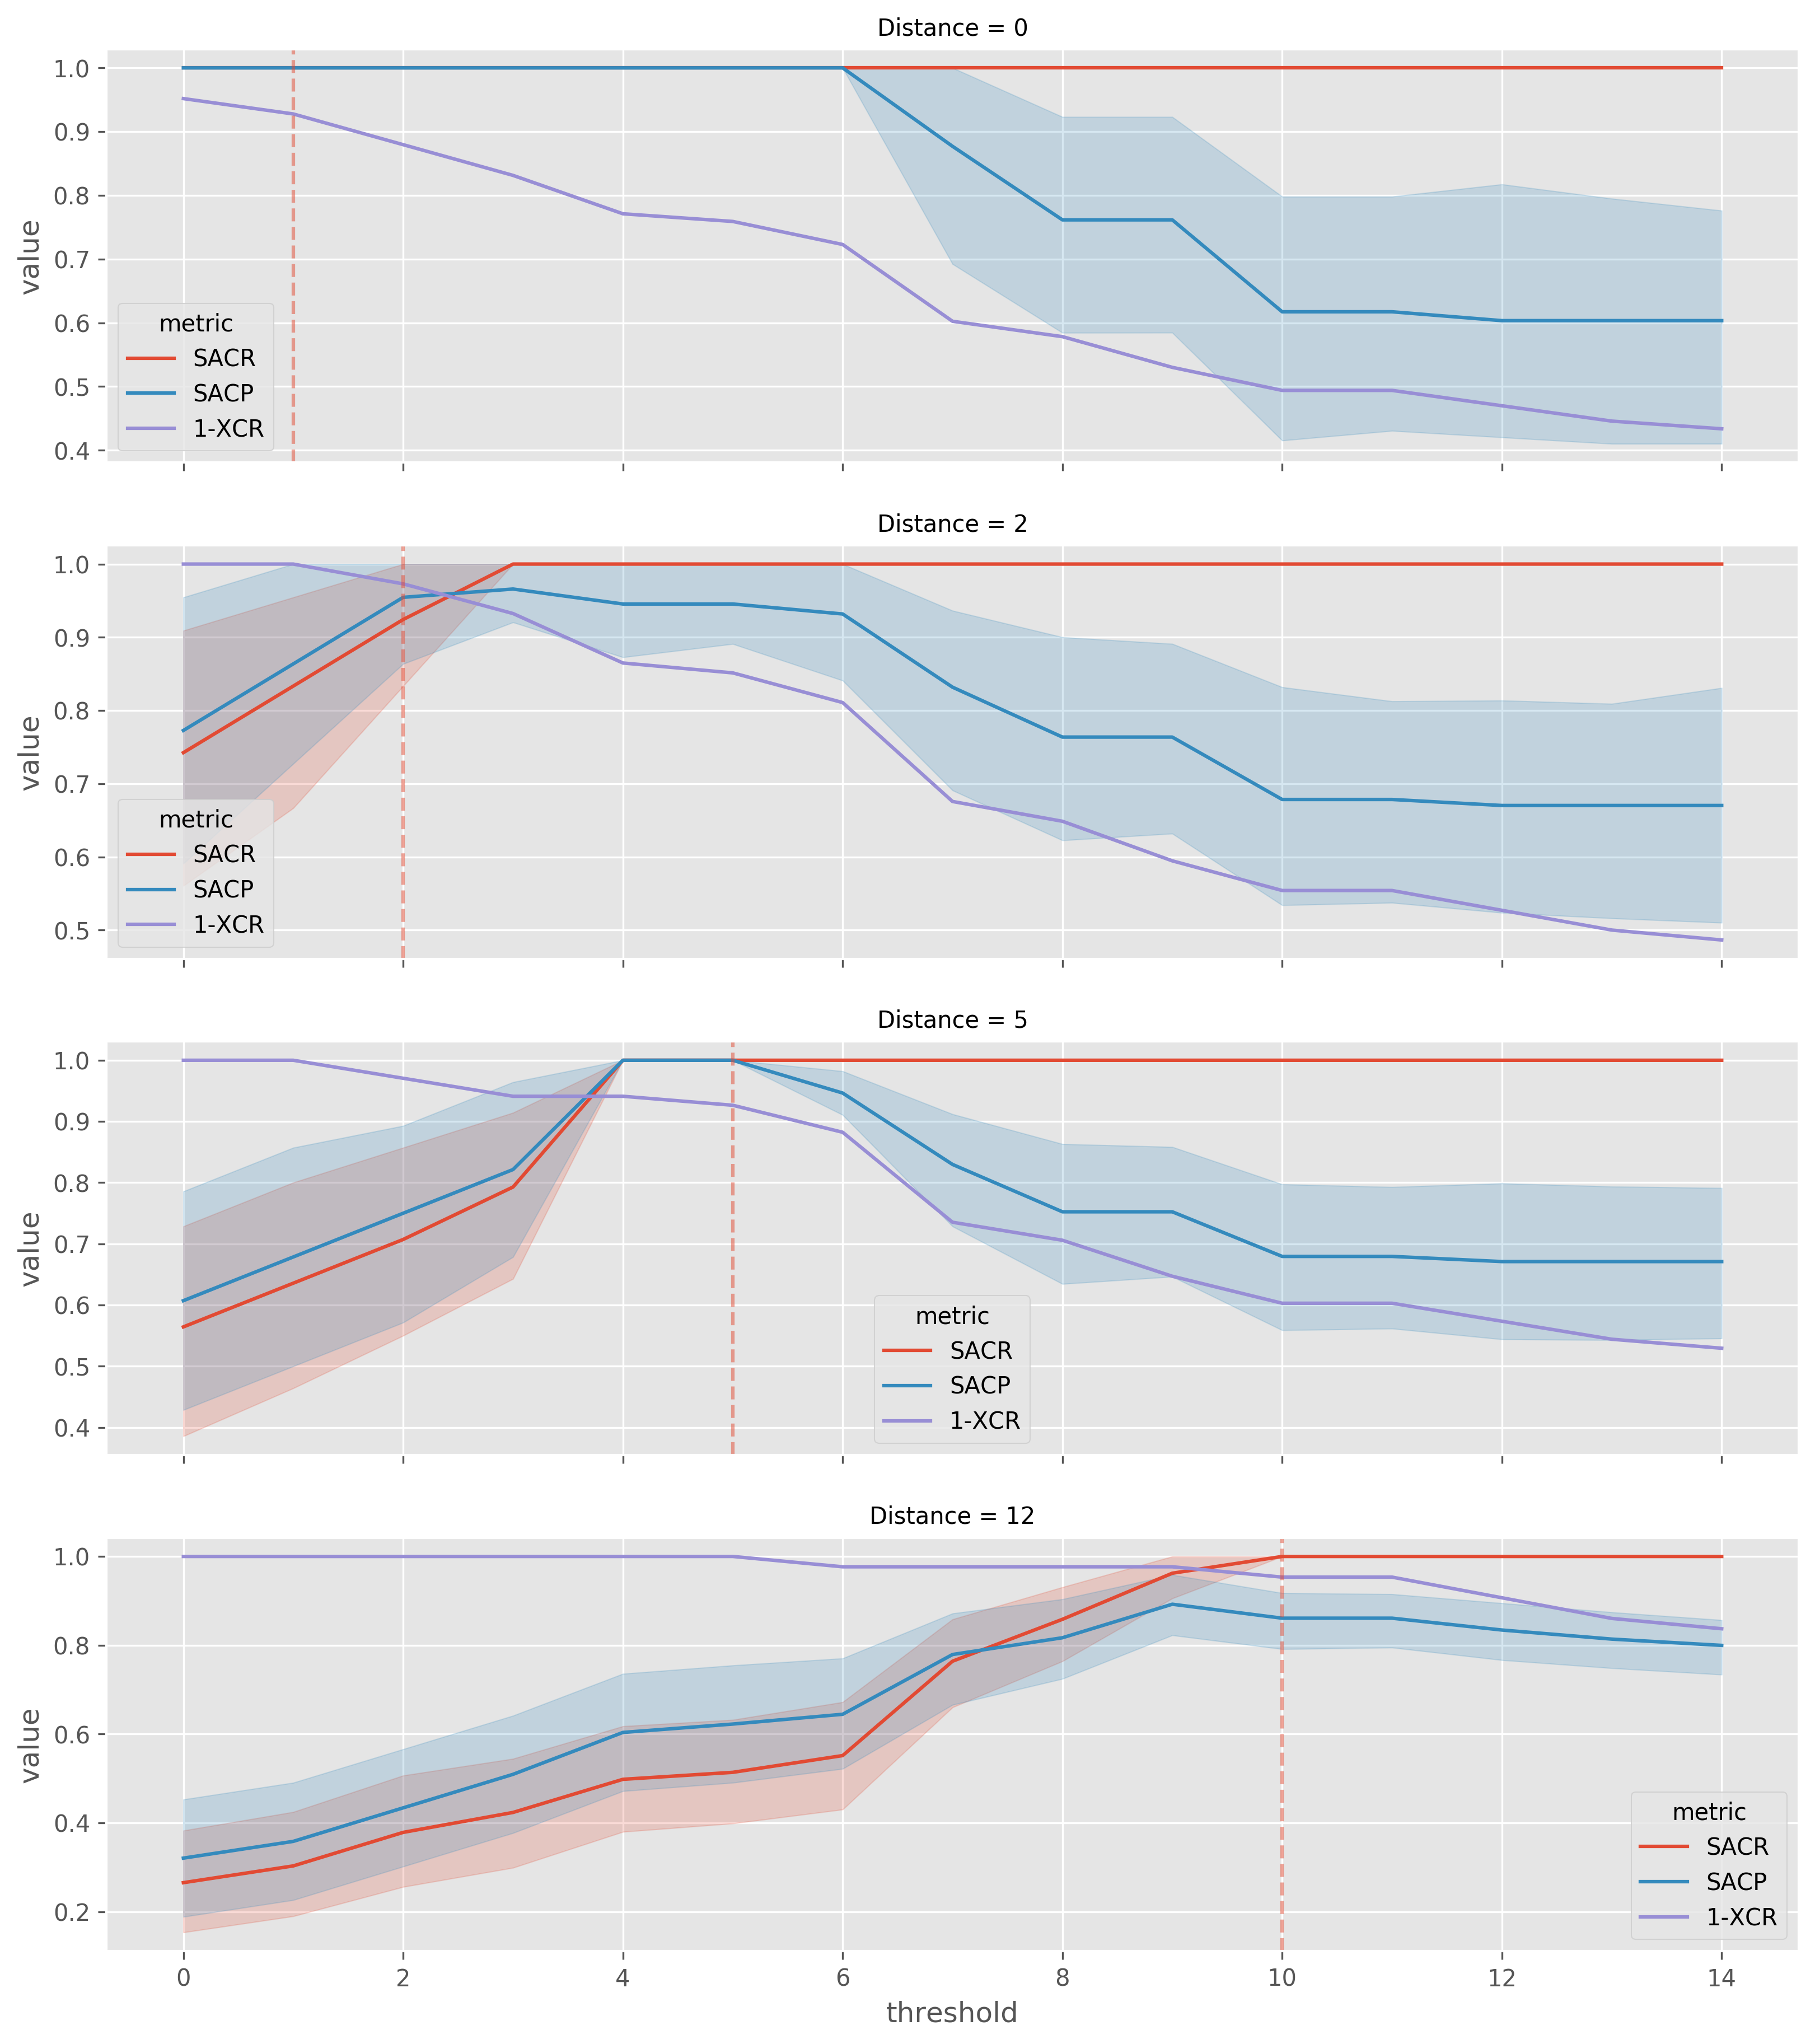

In [28]:
fig, axes = plt.subplots(nrows=len(distances), figsize=(13, 15), dpi=300, sharex=True)

for ax, dist, t in zip(axes.flatten(), distances, ont_dists):
    subdata = df.query("distance == @dist")
    sns.lineplot(data=subdata, x="threshold", y="value", hue="metric", ax=ax)
    pred_t = round(bcftools_threshold_converter(dist))
    if pred_t < 0:
        pred_t = 0
    ax.axvline(pred_t, alpha=0.5, linestyle="--")
    ax.set_title(f"Distance = {dist}", fontdict=dict(size=10))
#     print(subdata.query("threshold == @t").groupby(["metric"])["value"].describe())